In [1]:
import numpy as np
import skimage
import torch
import torchvision
import matplotlib.pyplot as plt
import torchxrayvision as xrv
from pathlib import Path

In [2]:
model = xrv.baseline_models.chestx_det.PSPNet()
root_dset_path = Path('/vol/biodata/data/chest_xray/VinDr-CXR/')
data_version = '1.0.0'
png_dset_path = root_dset_path / f'{data_version}_png_512' / 'raw'

In [136]:
lungs_and_hilus = [4,5,6,7]
weasand_and_spine = [12,13]

(2373, 2373, 3)
Setting XRayResizer engine to cv2 could increase performance.


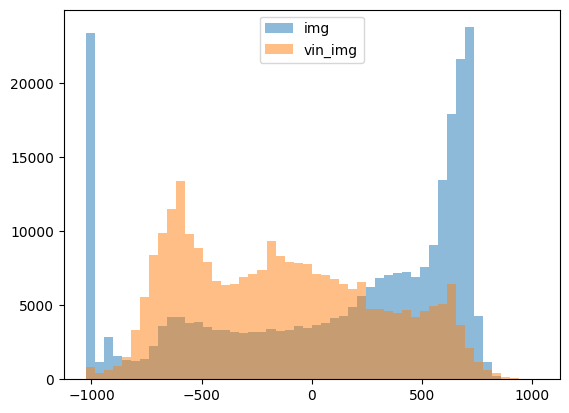

In [137]:
img = skimage.io.imread("covid-19-pneumonia-58-prior.jpg")
print(img.shape)
img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
img = img.mean(2)[None, ...] # Make single color channel

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(512)])
img = transform(img)
img = torch.from_numpy(img)

vin_img_path = png_dset_path / 'test' / '688ecdb1a4e994d42b5a50a8c4a9736f.png'
vin_img = skimage.io.imread(vin_img_path)
vin_img = xrv.datasets.normalize(vin_img, 255) # convert 8-bit image to [-1024, 1024] range
vin_img = torch.from_numpy(vin_img).reshape(1, 512, 512)

# plot pixel histograms of the two images
plt.figure()
plt.hist(img.numpy().flatten(), bins=50, alpha=0.5, label='img')
plt.hist(vin_img.numpy().flatten(), bins=50, alpha=0.5, label='vin_img')
plt.legend()
plt.show()

In [4]:
def preprocess_image(img_path):
    vin_img = skimage.io.imread(img_path)
    vin_img = xrv.datasets.normalize(vin_img, 255) # convert 8-bit image to [-1024, 1024] range
    vin_img = torch.from_numpy(vin_img).reshape(1, 512, 512)
    print(vin_img.shape)
    return vin_img

def predict_image(img_path, model):
    vin_img = preprocess_image(img_path)
    with torch.no_grad():
        pred = model(vin_img)
    return pred

def plot_prediction(img_path,pred,classes=[]):
    if len(classes) == 0:
        classes = list(range(len(model.targets)))

    plt.figure(figsize = (26,5))
    plt.subplot(1, len(classes) + 1, 1)
    plt.imshow(skimage.io.imread(img_path),cmap='gray')
    plt.axis('off')
    
    for index,model_index in enumerate(classes):
        plt.subplot(1, len(classes) + 1, index+2)
        plt.imshow(pred[0, model_index].cpu())
        plt.title(model.targets[model_index])
        plt.axis('off')
    plt.show()


torch.Size([1, 512, 512])


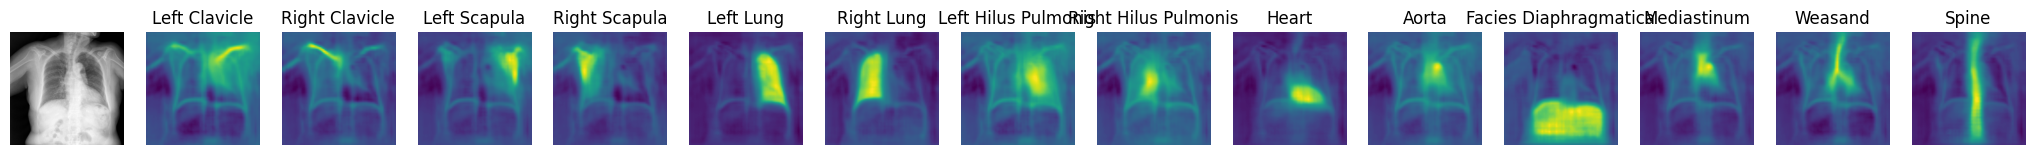

torch.Size([1, 512, 512])


NameError: name 'lungs_and_hilus' is not defined

In [5]:
vin_img_path = png_dset_path / 'test' / '9262bfe5dc41410f1725ebdd26a22334.png'
plot_prediction(vin_img_path,predict_image(vin_img_path, model))
plot_prediction(vin_img_path,predict_image(vin_img_path, model),lungs_and_hilus)

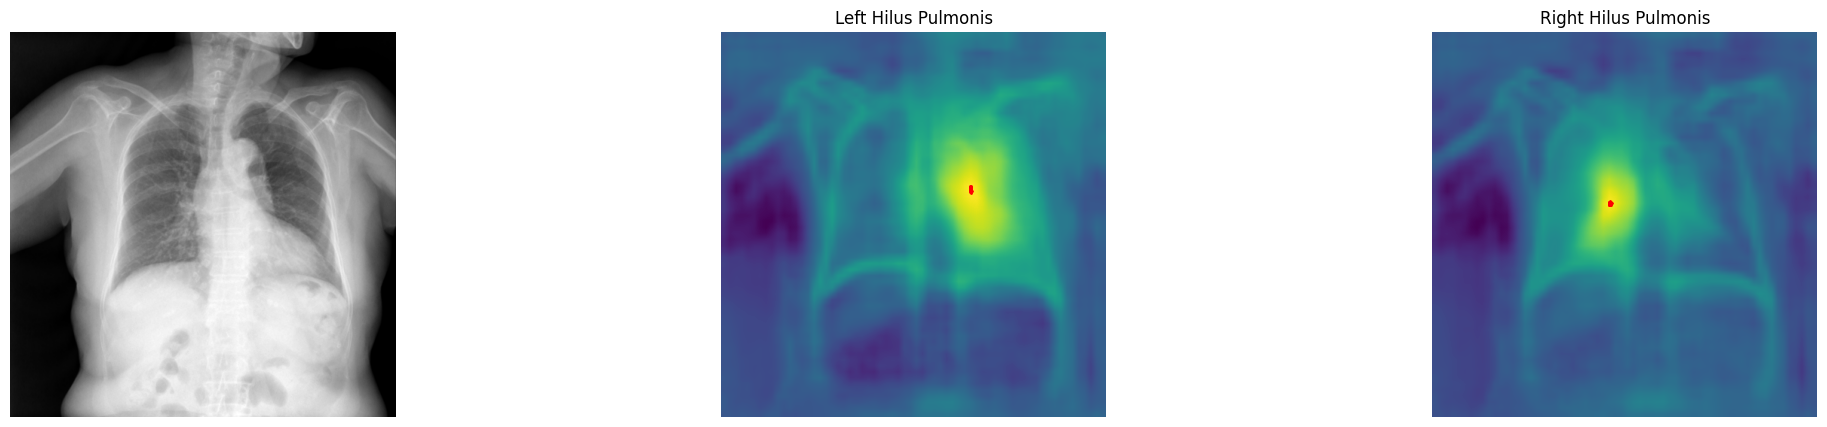

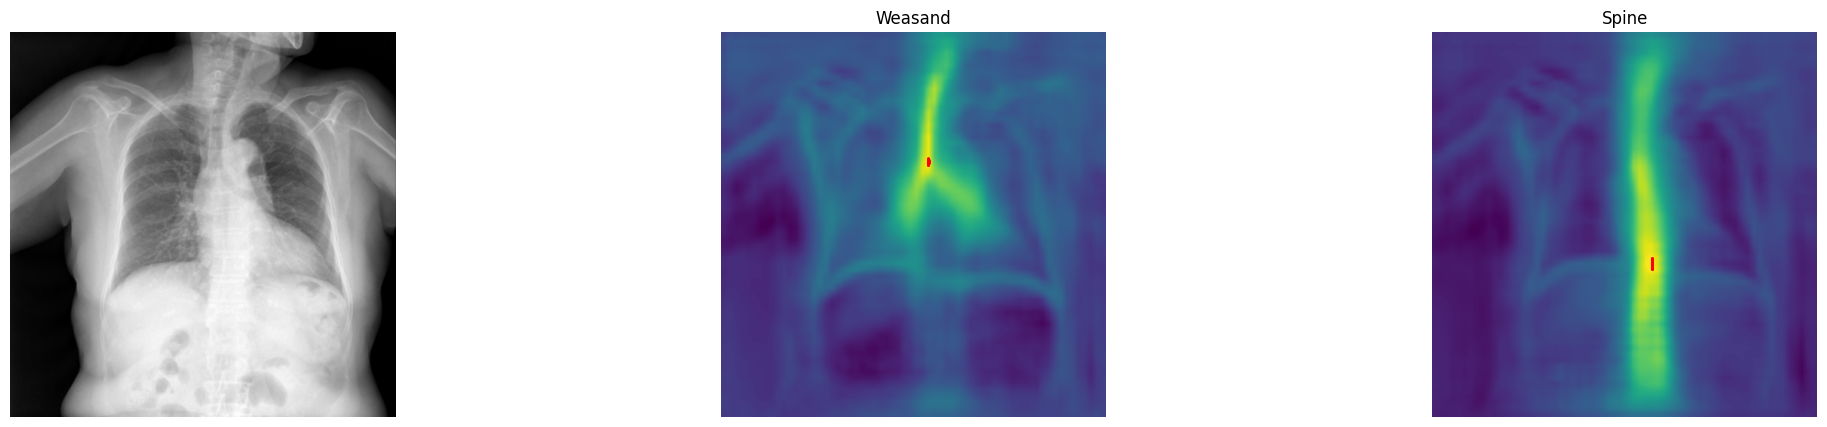

In [140]:
# get top n predicted pixels_for_certain_class
def get_top_n_pixels(pred,n,classes):
    top_n_pixels = []
    for class_index in classes:
        class_pred = pred[0, class_index]
        top_n_indices = torch.topk(class_pred.view(-1), n).indices
        top_n_pixels.append(top_n_indices)
    return top_n_pixels

def plot_top_n_pixels(img_path,pred,n,classes=[]):
    top_n_pixels = get_top_n_pixels(pred,n,classes)
    if len(classes) == 0:
        classes = list(range(len(model.targets)))

    plt.figure(figsize = (26,5))
    plt.subplot(1, len(classes) + 1, 1)
    plt.imshow(skimage.io.imread(img_path),cmap='gray')
    plt.axis('off')
    
    for index,model_index in enumerate(classes):
        plt.subplot(1, len(classes) + 1, index+2)
        plt.imshow(pred[0, model_index].cpu())
        plt.title(model.targets[model_index])
        plt.axis('off')
        for pixel_index in top_n_pixels[index]:
            row = pixel_index // 512
            col = pixel_index % 512
            plt.scatter(col,row, s=1, c='r')
    plt.show()

n = 20
plot_top_n_pixels(vin_img_path,predict_image(vin_img_path, model),n,[6,7])
plot_top_n_pixels(vin_img_path,predict_image(vin_img_path, model),n,weasand_and_spine)


In [141]:
        y,x = np.where(class_pred == 1)
        plt.scatter(x,y, s=1, c='r')
        plt.plot([x.min(), x.max()], [y.min(), y.min()], 'r')
        plt.plot([x.min(), x.max()], [y.max(), y.max()], 'r')
        plt.plot([x.min(), x.min()], [y.min(), y.max()], 'r')
        plt.plot([x.max(), x.max()], [y.min(), y.max()], 'r')

NameError: name 'class_pred' is not defined

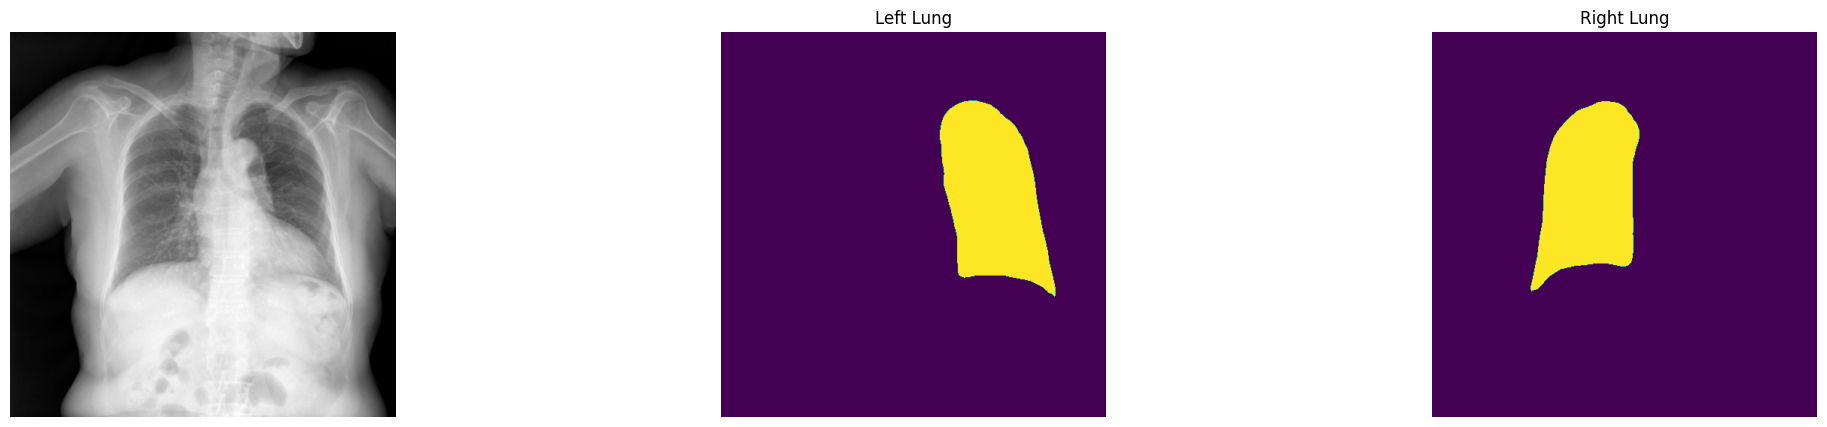

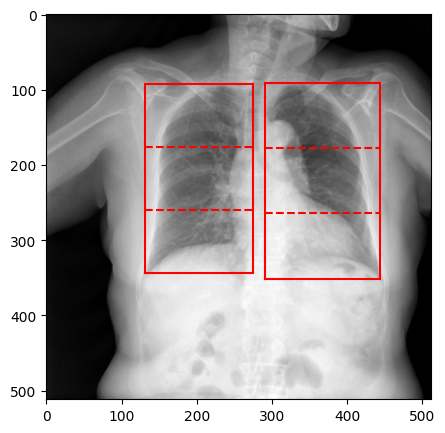

In [ ]:
# on lungs plot horizontal lines at pixel with smallest and highest y value
lungs = [4,5]

def get_class_pred(pred,class_index):
    class_pred = pred[0, class_index]
    class_pred = 1 / (1 + np.exp(-class_pred)) # use sigmoid to mask lungs
    class_pred[class_pred < 0.5] = 0
    class_pred[class_pred > 0.5] = 1
    return class_pred

def mask_lungs(img_path,pred):
    plt.figure(figsize = (26,5))
    plt.subplot(1, len(lungs) + 1, 1)
    plt.imshow(skimage.io.imread(img_path),cmap='gray')
    plt.axis('off')
    # use sigmoid to mask lungs
    for index,model_index in enumerate(lungs):
        class_pred = get_class_pred(pred,model_index)

        # plot class_pred
        plt.subplot(1, len(lungs) + 1, index+2)
        plt.imshow(class_pred)
        plt.title(model.targets[model_index])
        plt.axis('off')       
    plt.show()

mask_lungs(vin_img_path,predict_image(vin_img_path, model))

def bound_lungs(img_path,pred):
    plt.figure(figsize = (26,5))
    plt.subplot(1, len(lungs) + 1, 1)
    plt.imshow(skimage.io.imread(img_path),cmap='gray')

    for index,model_index in enumerate(lungs):
        class_pred = get_class_pred(pred,model_index)
        y,x = np.where(class_pred == 1)

        # plots a line from (x_min, x_max) and (y_min, y_max)
        plt.plot([x.min(), x.max()], [y.min(), y.min()], 'r')
        plt.plot([x.min(), x.max()], [y.max(), y.max()], 'r')
        plt.plot([x.min(), x.min()], [y.min(), y.max()], 'r')
        plt.plot([x.max(), x.max()], [y.min(), y.max()], 'r')

        # add two lines to split lungs into thirds
        plt.plot([x.min(), x.max()], [y.min() + (y.max() - y.min()) / 3, y.min() + (y.max() - y.min()) / 3], 'r', linestyle='dashed')
        plt.plot([x.min(), x.max()], [y.min() + 2 * (y.max() - y.min()) / 3, y.min() + 2 * (y.max() - y.min()) / 3], 'r', linestyle='dashed')

    plt.show()

bound_lungs(vin_img_path,predict_image(vin_img_path, model))



In [143]:
png_dset_path_test_labels = png_dset_path / 'annotations' / 'image_labels_test.csv'
with open(png_dset_path_test_labels, 'r') as f:
    next(f) # skip 
    # get first 50 lines columns 0
    image_ids = [line.split(',')[0] for line in f][:50]

['e0dc2e79105ad93532484e956ef8a71a', '0aed23e64ebdea798486056b4f174424', 'aa15cfcfca7605465ca0513902738b95', '665c4a6d2693dc0286d65ab479c9b169', '42da2c134b53cb5594774d3d29faac59', 'c7179539654a1b3b7977e56e7e3009d5', 'bfd1974dc9778aadb407a11b57ab748f', '618777b8305b062583337d9a6b7a3d4e', 'e54b5a593bc03c789ecdc18d8270964e', '3019aec706bd013e1e3348564fbfd086', 'efbe54fcf4bdab5041ecdf15af5fcd52', '40497da14aafc428210b623fc8445288', '934e2731a86f3a6d750f7f7d9eaea85c', '91123b24b8a4c289820bbb2dc6dabdfe', '688ecdb1a4e994d42b5a50a8c4a9736f', '5c55f871429730b84a8ee275839b8aae', 'bf754344a692a87c08c480dccf75e0c6', '6cbbbc0e77251e60d6f4af673cc19e2a', '9b609fc8e82081f4ac5bf83b8a0fbc5c', '31b4de538dd6272b05e295142c5ccc2a', '9262bfe5dc41410f1725ebdd26a22334', '97f0ad3b3ccbfc848bf9cc7e1a76377c', '56237d3770e31568eb965067d2d948af', '218e819ed8c0fe25c92ee7f1d5b993c7', '39077a997b195cfedd2287c9e9476b38', '6cd9d28658e91fe717e33e2f8b10e81a', 'b4e78fa47b3675c8de1ceae320bc4bf9', 'ae764a3ffd1b0317e4496637b3

#### Will take about 1 hour for test set & 5 hours for training set to segment

In [144]:
# setup some profiling code to measure average and max time to predict an image
import time
times = []
for image_id in image_ids:
    vin_img_path = png_dset_path / 'test' / f'{image_id}.png'
    start = time.time()
    predict_image(vin_img_path, model)
    end = time.time()
    times.append(end - start)

print(f'Average time to predict an image: {np.mean(times)}') # in seconds 
print(f'Max time to predict an image: {np.max(times)}')


Average time to predict an image: 1.036814842224121
Max time to predict an image: 1.1938152313232422


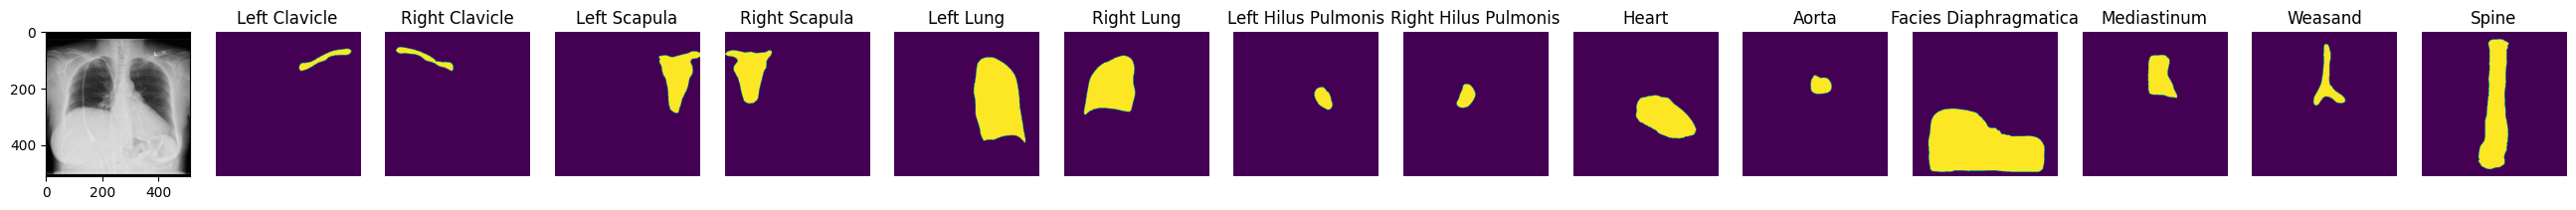

In [ ]:
pred = 1 / (1 + np.exp(-pred))  # sigmoid
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1

plt.figure(figsize = (26,5))
plt.subplot(1, len(model.targets) + 1, 1)
plt.imshow(img[0], cmap='gray')
for i in range(len(model.targets)):
    plt.subplot(1, len(model.targets) + 1, i+2)
    plt.imshow(pred[0, i])
    plt.title(model.targets[i])
    plt.axis('off')
plt.tight_layout()